This notebook analyses precipitation data to assess future flood risk in London. It generates visualizations that illustrate projected changes in rainfall patterns under different climate scenarios.

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be

Return Period Comparison:
     Historical (1985-2014)  SSP2-4.5 (2041-2070)  SSP2-4.5 (2071-2100)  \
2                  3.840371              3.834579              4.104882   
5                  4.943521              4.683336              5.076680   
10                 5.700103              5.155447              5.696573   
20                 6.446096              5.551029              6.274174   
50                 7.442065              5.991158              6.997848   
100                8.211524              6.274924              7.522953   

     SSP5-8.5 (2041-2070)  SSP5-8.5 (2071-2100)  
2                4.381755              4.777563  
5                5.457455              5.966334  
10               6.068751              6.705973  
20               6.589501              7.381921  
50               7.179684              8.210611  
100              7.567281              8.799110  

Flood Risk Relative to Historical Period (threshold: 19.20 mm):
Historical (1985-2014): 1.00x
SSP

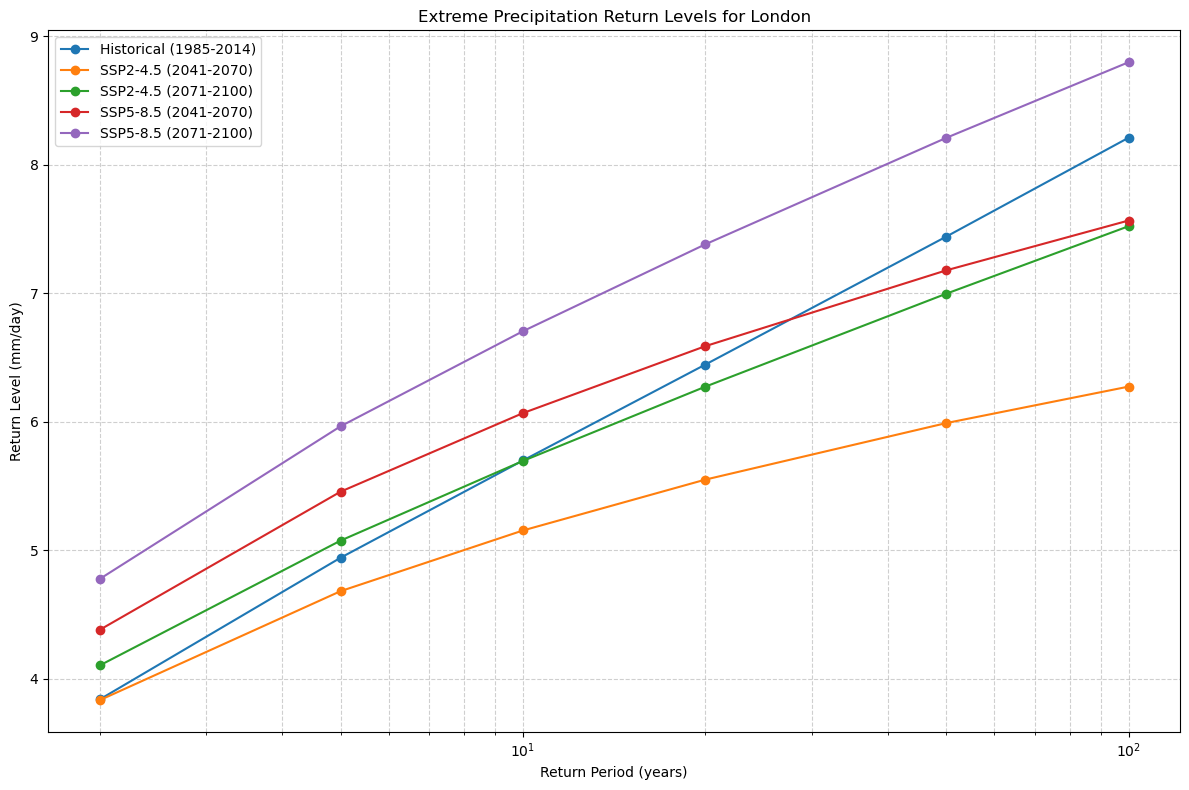

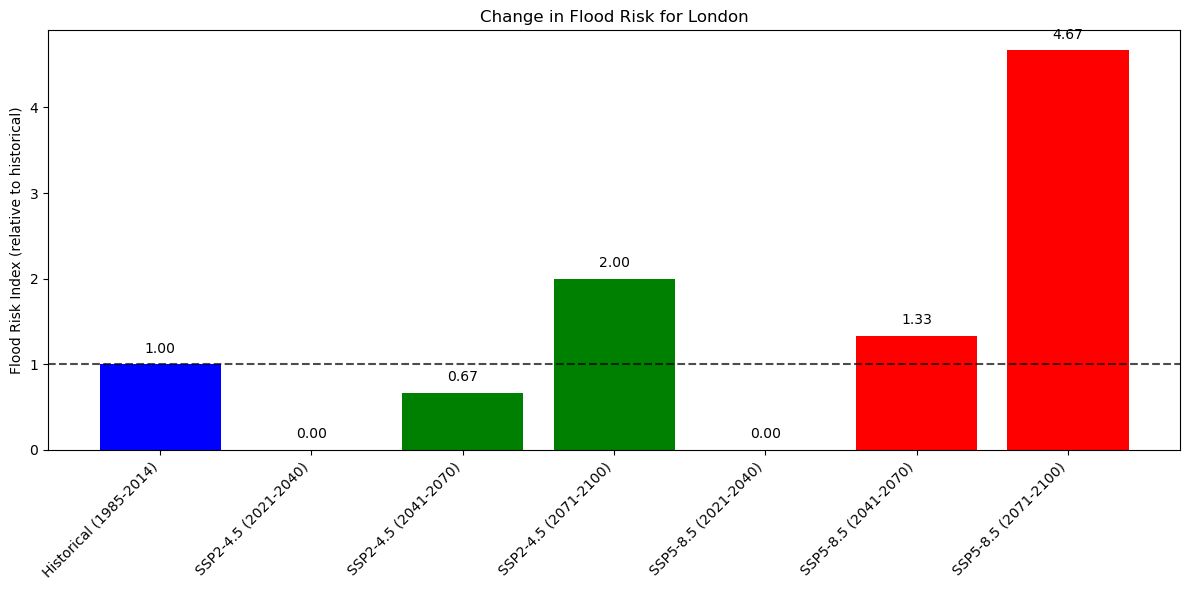

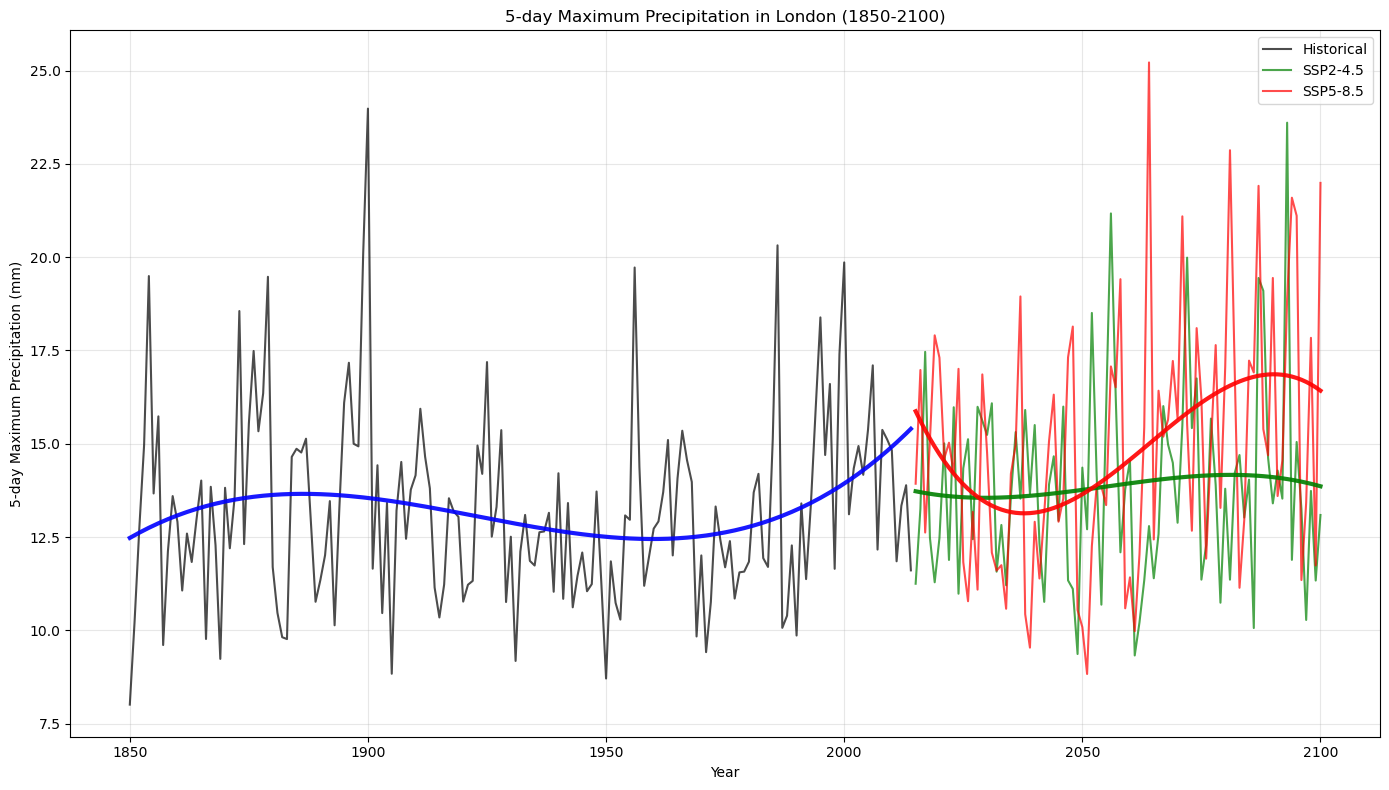

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Load the NetCDF files
def load_data():
    # Historical data
    hist_precip = xr.open_dataset('datasets/cmip6_pr_historical_UKESM1-0-LL.nc')
    
    # Future scenarios
    ssp245_precip = xr.open_dataset('datasets/cmip6_pr_ssp245_UKESM1-0-LL.nc')
    ssp585_precip = xr.open_dataset('datasets/cmip6_pr_ssp585_UKESM1-0-LL.nc')
    
    return hist_precip, ssp245_precip, ssp585_precip

# Extract data for London (approximate coordinates)
def extract_london_data(dataset):
    # London coordinates (approximate)
    lon_london = -0.1278
    lat_london = 51.5074
    
    # Find nearest grid point
    london_data = dataset.sel(lon=lon_london, lat=lat_london, method='nearest')
    return london_data

# Calculate extreme precipitation metrics
def calculate_extremes(dataset):
    # Convert from kg/m^2/s to mm/day if needed (multiply by 86400)
    if dataset.pr.units in ['kg m-2 s-1', 'kg/m2/s']:
        precip_daily = dataset.pr * 86400
    else:
        precip_daily = dataset.pr
    
    # Calculate metrics
    # 1. Annual maximum daily precipitation
    annual_max = precip_daily.resample(time='Y').max()
    
    # 2. Number of days with precipitation > 20mm (heavy rain)
    heavy_rain_days = (precip_daily > 20).resample(time='Y').sum()
    
    # 3. 5-day cumulative maximum precipitation (relevant for flooding)
    rolling_5d = precip_daily.rolling(time=5).sum()
    annual_max_5day = rolling_5d.resample(time='Y').max()
    
    return {
        'annual_max': annual_max,
        'heavy_rain_days': heavy_rain_days,
        'annual_max_5day': annual_max_5day
    }

# Perform extreme value analysis (fit GEV distribution)
def extreme_value_analysis(annual_max_series):
    # Convert to numpy array for fitting
    data = annual_max_series.values
    
    # Fit Generalized Extreme Value distribution
    shape, loc, scale = stats.genextreme.fit(data)
    
    # Calculate return levels for different periods
    return_periods = [2, 5, 10, 20, 50, 100]
    return_levels = {}
    
    for rp in return_periods:
        # Calculate return level
        p = 1 - 1/rp
        return_level = stats.genextreme.ppf(p, shape, loc, scale)
        return_levels[rp] = return_level
    
    return {
        'gev_params': (shape, loc, scale),
        'return_levels': return_levels
    }

# Compare return periods between historical and future scenarios
def compare_return_periods(hist_extremes, ssp245_extremes, ssp585_extremes):
    # Define periods for comparison
    hist_period = slice('1985', '2014')  # Recent historical 30-year period
    future_period_mid = slice('2041', '2070')  # Mid-century
    future_period_late = slice('2071', '2100')  # Late century
    
    # Extract data for these periods
    hist_data = hist_extremes['annual_max'].sel(time=hist_period)
    ssp245_mid = ssp245_extremes['annual_max'].sel(time=future_period_mid)
    ssp245_late = ssp245_extremes['annual_max'].sel(time=future_period_late)
    ssp585_mid = ssp585_extremes['annual_max'].sel(time=future_period_mid)
    ssp585_late = ssp585_extremes['annual_max'].sel(time=future_period_late)
    
    # Perform EVA for each period
    hist_eva = extreme_value_analysis(hist_data)
    ssp245_mid_eva = extreme_value_analysis(ssp245_mid)
    ssp245_late_eva = extreme_value_analysis(ssp245_late)
    ssp585_mid_eva = extreme_value_analysis(ssp585_mid)
    ssp585_late_eva = extreme_value_analysis(ssp585_late)
    
    # Create comparison dataframe
    return_periods = [2, 5, 10, 20, 50, 100]
    comparison = pd.DataFrame(index=return_periods)
    
    comparison['Historical (1985-2014)'] = [hist_eva['return_levels'][rp] for rp in return_periods]
    comparison['SSP2-4.5 (2041-2070)'] = [ssp245_mid_eva['return_levels'][rp] for rp in return_periods]
    comparison['SSP2-4.5 (2071-2100)'] = [ssp245_late_eva['return_levels'][rp] for rp in return_periods]
    comparison['SSP5-8.5 (2041-2070)'] = [ssp585_mid_eva['return_levels'][rp] for rp in return_periods]
    comparison['SSP5-8.5 (2071-2100)'] = [ssp585_late_eva['return_levels'][rp] for rp in return_periods]
    
    return comparison

# Calculate extreme precipitation metrics for monthly data
def calculate_monthly_extremes(dataset):
    # Convert from kg/m^2/s to mm/month if needed
    if dataset.pr.units in ['kg m-2 s-1', 'kg/m2/s']:
        # Average seconds in a month: ~2,628,000
        precip_monthly = dataset.pr * 2628000
    else:
        precip_monthly = dataset.pr
    
    # Calculate metrics
    # 1. Annual maximum monthly precipitation
    annual_max = precip_monthly.resample(time='Y').max()
    
    # 2. Number of months with precipitation > 100mm (adjust threshold as appropriate)
    heavy_rain_months = (precip_monthly > 100).resample(time='Y').sum()
    
    # 3. 3-month cumulative maximum precipitation (for seasonal flooding)
    rolling_3m = precip_monthly.rolling(time=3).sum()
    annual_max_3month = rolling_3m.resample(time='Y').max()
    
    return {
        'annual_max': annual_max,
        'heavy_rain_months': heavy_rain_months,
        'annual_max_3month': annual_max_3month
    }

# Modified flood risk indicator for monthly data
def calculate_monthly_flood_risk_indicator(hist_data, ssp245_data, ssp585_data):
    # Define periods
    hist_period = slice('1985', '2014')
    future_periods = [slice('2021', '2040'), slice('2041', '2070'), slice('2071', '2100')]
    period_names = ['2021-2040', '2041-2070', '2071-2100']
    
    # Calculate historical threshold for flooding (95th percentile of 3-month precipitation)
    hist_3month = hist_data['annual_max_3month'].sel(time=hist_period)
    flood_threshold = np.percentile(hist_3month, 95)
    
    # Calculate how often this threshold is exceeded in future periods
    results = {'Historical (1985-2014)': 1.0}  # Baseline
    
    # SSP2-4.5
    for period, name in zip(future_periods, period_names):
        future_3month = ssp245_data['annual_max_3month'].sel(time=period)
        exceed_prob = (future_3month > flood_threshold).mean()
        results[f'SSP2-4.5 ({name})'] = float(exceed_prob) / 0.05  # Normalized to historical
    
    # SSP5-8.5
    for period, name in zip(future_periods, period_names):
        future_3month = ssp585_data['annual_max_3month'].sel(time=period)
        exceed_prob = (future_3month > flood_threshold).mean()
        results[f'SSP5-8.5 ({name})'] = float(exceed_prob) / 0.05  # Normalized to historical
    
    return results, flood_threshold

# Visualization functions
def plot_return_level_comparison(comparison_df):
    plt.figure(figsize=(12, 8))
    
    # Plot return levels
    for column in comparison_df.columns:
        plt.plot(comparison_df.index, comparison_df[column], marker='o', label=column)
    
    plt.xscale('log')
    plt.xlabel('Return Period (years)')
    plt.ylabel('Return Level (mm/day)')
    plt.title('Extreme Precipitation Return Levels for London')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()

def plot_flood_risk_change(flood_risk_dict):
    scenarios = list(flood_risk_dict.keys())
    values = list(flood_risk_dict.values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(scenarios, values, color=['blue'] + ['green']*3 + ['red']*3)
    
    # Add horizontal line at baseline
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Flood Risk Index (relative to historical)')
    plt.title('Change in Flood Risk for London')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()

def plot_time_series(hist_data, ssp245_data, ssp585_data, metric='annual_max'):
    plt.figure(figsize=(14, 8))
    
    # Plot historical data
    hist_series = hist_data[metric]
    x_hist = hist_series.time.dt.year
    y_hist = hist_series.values
    plt.plot(x_hist, y_hist, color='black', alpha=0.7, label='Historical')
    
    # Plot SSP2-4.5
    ssp245_series = ssp245_data[metric]
    x_ssp245 = ssp245_series.time.dt.year
    y_ssp245 = ssp245_series.values
    plt.plot(x_ssp245, y_ssp245, color='green', alpha=0.7, label='SSP2-4.5')
    
    # Plot SSP5-8.5
    ssp585_series = ssp585_data[metric]
    x_ssp585 = ssp585_series.time.dt.year
    y_ssp585 = ssp585_series.values
    plt.plot(x_ssp585, y_ssp585, color='red', alpha=0.7, label='SSP5-8.5')
    
    # Add smoothed trendlines
    def add_trendline(x, y, color, alpha=0.9):
        # Use a polynomial fit for the trend
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        plt.plot(x, p(x), color=color, linewidth=3, alpha=alpha)
    
    add_trendline(x_hist, y_hist, 'blue')
    add_trendline(x_ssp245, y_ssp245, 'green')
    add_trendline(x_ssp585, y_ssp585, 'red')
    
    if metric == 'annual_max':
        ylabel = 'Annual Maximum Daily Precipitation (mm/day)'
        title = 'Annual Maximum Precipitation in London (1850-2100)'
    elif metric == 'annual_max_5day':
        ylabel = '5-day Maximum Precipitation (mm)'
        title = '5-day Maximum Precipitation in London (1850-2100)'
    else:
        ylabel = 'Value'
        title = 'Climate Metric Time Series'
    
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()

# Main execution
def main():
    # Load data
    hist_precip, ssp245_precip, ssp585_precip = load_data()
    
    # Extract London data
    london_hist = extract_london_data(hist_precip)
    london_ssp245 = extract_london_data(ssp245_precip)
    london_ssp585 = extract_london_data(ssp585_precip)
    
    # Calculate extremes
    hist_extremes = calculate_extremes(london_hist)
    ssp245_extremes = calculate_extremes(london_ssp245)
    ssp585_extremes = calculate_extremes(london_ssp585)
    
    # Compare return periods
    comparison = compare_return_periods(hist_extremes, ssp245_extremes, ssp585_extremes)
    print("Return Period Comparison:")
    print(comparison)
    
    # Calculate flood risk indicator
    flood_risk, threshold = calculate_flood_risk_indicator(hist_extremes, ssp245_extremes, ssp585_extremes)
    print(f"\nFlood Risk Relative to Historical Period (threshold: {threshold:.2f} mm):")
    for scenario, risk in flood_risk.items():
        print(f"{scenario}: {risk:.2f}x")
    
    # Create visualizations
    return_level_fig = plot_return_level_comparison(comparison)
    #return_level_fig.savefig('figures/london_return_levels.png', dpi=300)
    
    flood_risk_fig = plot_flood_risk_change(flood_risk)
    #flood_risk_fig.savefig('figures/london_flood_risk_change.png', dpi=300)
    
    time_series_fig = plot_time_series(hist_extremes, ssp245_extremes, ssp585_extremes, 'annual_max_5day')
    #time_series_fig.savefig('figures/london_precipitation_timeseries.png', dpi=300)
    
    return {
        'comparison': comparison,
        'flood_risk': flood_risk,
        'threshold': threshold,
        'figures': {
            'return_levels': return_level_fig,
            'flood_risk': flood_risk_fig,
            'time_series': time_series_fig
        }
    }

if __name__ == "__main__":
    results = main()